# Experiment 1: Baseline Validation on 2-Player Kuhn Poker

**Objective**: Compare **Monte Carlo CFR** (MCCFR) variants with **Full-Width CFR** (textbook-accurate) on 2-Player Kuhn Poker.

**Algorithms Compared**:
1. **MCCFR (Vanilla)** - Monte Carlo sampling at chance nodes
2. **MCCFR+** - Monte Carlo with regret flooring + linear averaging
3. **Full-Width CFR (Vanilla)** - Textbook algorithm, full expectation at chance nodes
4. **Full-Width CFR+** - Textbook CFR+ with regret flooring + linear averaging

**Hypothesis**: 
- Full-width variants should show smoother convergence (no sampling variance)
- CFR+ variants should converge faster than vanilla (O(1/T) vs O(1/√T))
- The difference should be more visible in full-width versions

**Metrics**:
*   **NashConv**: Measures the "distance" from a Nash Equilibrium. 0 = Perfect Equilibrium.

In [1]:
%matplotlib inline
import pyspiel
import numpy as np
import matplotlib.pyplot as plt
from solvers import CFRSolver, CFRPlusSolver, FullWidthCFRSolver, FullWidthCFRPlusSolver

print("OpenSpiel installed successfully!")
print(f"Number of games available: {len(pyspiel.registered_games())}")

Optional module pokerkit_wrapper was not importable: No module named 'pokerkit'
OpenSpiel installed successfully!
Number of games available: 121


Training MCCFR (Vanilla)...
Iteration 1000/5000 - NashConv: 0.069972
Iteration 2000/5000 - NashConv: 0.048401
Iteration 3000/5000 - NashConv: 0.022829
Iteration 4000/5000 - NashConv: 0.029464
Iteration 5000/5000 - NashConv: 0.014391
Training MCCFR+...
Iteration 1000/5000 - NashConv: 0.054232
Iteration 2000/5000 - NashConv: 0.044569
Iteration 3000/5000 - NashConv: 0.035498
Iteration 4000/5000 - NashConv: 0.021067
Iteration 5000/5000 - NashConv: 0.025088
Training Full-Width CFR (Vanilla)...
Iteration 1000/5000 - NashConv: 0.013007
Iteration 2000/5000 - NashConv: 0.009455
Iteration 3000/5000 - NashConv: 0.007646
Iteration 4000/5000 - NashConv: 0.006634
Iteration 5000/5000 - NashConv: 0.005942
Training Full-Width CFR+...
Iteration 1000/5000 - NashConv: 0.009709
Iteration 2000/5000 - NashConv: 0.006791
Iteration 3000/5000 - NashConv: 0.005549
Iteration 4000/5000 - NashConv: 0.004817
Iteration 5000/5000 - NashConv: 0.004314


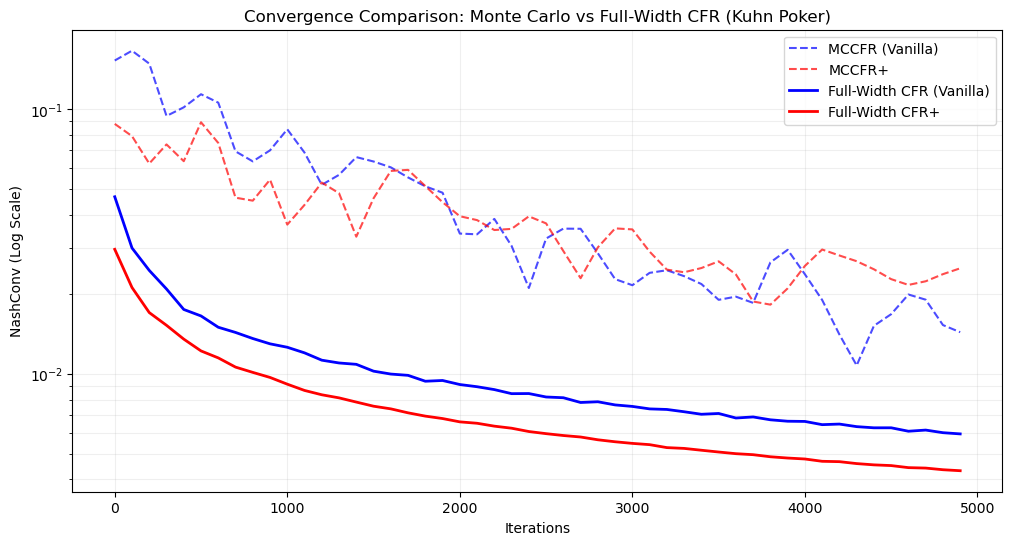


=== Final NashConv Values ===
MCCFR (Vanilla):      0.014391
MCCFR+:               0.025088
Full-Width CFR:       0.005942
Full-Width CFR+:      0.004314


In [2]:
# Compare all 4 CFR variants on 2-Player Kuhn Poker
game = pyspiel.load_game("kuhn_poker")
iterations = 5000
log_every = 100

# Monte Carlo variants (original implementation)
print("Training MCCFR (Vanilla)...")
solver_mc_vanilla = CFRSolver(game)
history_mc_vanilla = solver_mc_vanilla.train(iterations, log_every=log_every)

print("Training MCCFR+...")
solver_mc_plus = CFRPlusSolver(game)
history_mc_plus = solver_mc_plus.train(iterations, log_every=log_every)

# Full-width variants (textbook accurate)
print("Training Full-Width CFR (Vanilla)...")
solver_fw_vanilla = FullWidthCFRSolver(game)
history_fw_vanilla = solver_fw_vanilla.train(iterations, log_every=log_every)

print("Training Full-Width CFR+...")
solver_fw_plus = FullWidthCFRPlusSolver(game)
history_fw_plus = solver_fw_plus.train(iterations, log_every=log_every)

# Plotting
x_axis = np.arange(len(history_mc_vanilla['nash_conv'])) * log_every

plt.figure(figsize=(12, 6))

# Monte Carlo variants (dashed lines)
plt.plot(x_axis, history_mc_vanilla['nash_conv'], 'b--', label="MCCFR (Vanilla)", alpha=0.7)
plt.plot(x_axis, history_mc_plus['nash_conv'], 'r--', label="MCCFR+", alpha=0.7)

# Full-width variants (solid lines)
plt.plot(x_axis, history_fw_vanilla['nash_conv'], 'b-', label="Full-Width CFR (Vanilla)", linewidth=2)
plt.plot(x_axis, history_fw_plus['nash_conv'], 'r-', label="Full-Width CFR+", linewidth=2)

plt.yscale("log")
plt.title("Convergence Comparison: Monte Carlo vs Full-Width CFR (Kuhn Poker)")
plt.xlabel("Iterations")
plt.ylabel("NashConv (Log Scale)")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

print("\n=== Final NashConv Values ===")
print(f"MCCFR (Vanilla):      {history_mc_vanilla['nash_conv'][-1]:.6f}")
print(f"MCCFR+:               {history_mc_plus['nash_conv'][-1]:.6f}")
print(f"Full-Width CFR:       {history_fw_vanilla['nash_conv'][-1]:.6f}")
print(f"Full-Width CFR+:      {history_fw_plus['nash_conv'][-1]:.6f}")

## Result Interpretation

The plot compares Monte Carlo CFR (dashed lines) with Full-Width/Textbook CFR (solid lines):

### Key Observations:

1. **Full-Width CFR shows smoother convergence**: The solid lines should be much smoother than the dashed lines because full-width CFR computes exact expectations over chance nodes, eliminating sampling variance.

2. **CFR+ converges faster**: Compare blue vs red lines. CFR+ (red) should converge faster due to:
   - **Regret flooring**: Clamping negative regrets to 0 prevents "unlearning" good actions
   - **Linear averaging**: Weighting later strategies more heavily

3. **Monte Carlo variance**: The dashed lines (MCCFR) show oscillations because each iteration samples only one chance outcome, introducing noise.

4. **Theoretical rates**:
   - Vanilla CFR: O(1/√T) convergence
   - CFR+: O(1/T) convergence (faster)
   
   This difference is most visible in the Full-Width versions where sampling noise doesn't mask the effect.

### Why Use Monte Carlo?
Despite worse per-iteration convergence, MCCFR is often preferred in practice because:
- Full-width traversal is exponentially expensive in games with many chance outcomes
- MCCFR scales to large games like Texas Hold'em where full traversal is impossible